In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import poisson_atac as patac
import scanpy as sc

In [31]:
import scipy.sparse
from pytorch_lightning.loggers import WandbLogger
import wandb
import numpy as np

In [4]:
adata = patac.data.load_neurips()

In [6]:
adata.layers["counts"] = scipy.sparse.csr_matrix(adata.layers["counts"])

In [7]:
adata

AnnData object with n_obs × n_vars = 42492 × 116490
    obs: 'nCount_peaks', 'atac_fragments', 'reads_in_peaks_frac', 'blacklist_fraction', 'nucleosome_signal', 'cell_type', 'pseudotime_order_ATAC', 'batch', 'pseudotime_order_GEX', 'is_train'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism', 'sample_pm_varnames'
    obsm: 'gene_activity', 'lsi_full', 'lsi_red', 'umap'
    layers: 'counts'

# Run scvi on "corrected" ATAC with poisson loss

In [14]:
import scvi

In [15]:
atac = adata[adata.obs.batch == 's1d1'].copy()

In [32]:
atac.layers["counts"].data = np.ceil(atac.layers["counts"].data/2)

In [33]:
atac.layers["counts"].max()

94.0

In [34]:
scvi.model.SCVI.setup_anndata(atac, layer="counts")

In [48]:
model = scvi.model.SCVI(adata=atac, gene_likelihood="poisson" )

In [49]:
#setup logger
logger = WandbLogger(project=f"poisson_atac")
logger.watch(model.module, log='all')

#train model
model.train(logger=logger,train_size=0.8, validation_size=0.1, early_stopping=True, early_stopping_monitor="reconstruction_loss_validation")
wandb.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 84/400:  21%|██        | 84/400 [05:25<20:24,  3.87s/it, loss=1.11e+04, v_num=vz6r]


elbo_train,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
elbo_validation,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
kl_global_train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_global_validation,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_local_train,▁▂▄▆▇▇███████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
kl_local_validation,▁▃▅▆▇███████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅
reconstruction_loss_train,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss_validation,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_epoch,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,██▅▆▆▄▅▆▇▇▆▆▄▅▁▆▆▆▃▆▅▆▄▅▄▆▅▆▇▆▅▄▅▃▄▅▅▆▅▅


In [50]:
X_emb = model.get_latent_representation(atac)

In [51]:
def compute_embedding(adata, X_emb):
            
    adata.obsm['X_emb'] = X_emb
    
    if 'X_umap' in adata.obsm.keys():
        adata.obsm.pop('X_umap')
    
    if 'umap' in adata.obsm.keys():
        adata.obsm.pop('umap')
        
    if 'neighbors' in adata.uns.keys():
        adata.uns.pop('neighbors')

    sc.pp.neighbors(adata, use_rep='X_emb')
    sc.tl.umap(adata)

In [52]:
compute_embedding(atac, X_emb)

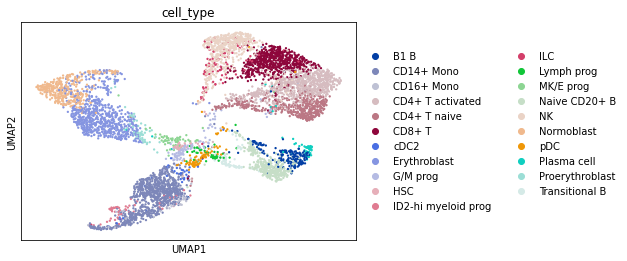

In [53]:
sc.pl.umap(atac, color = ["cell_type"])

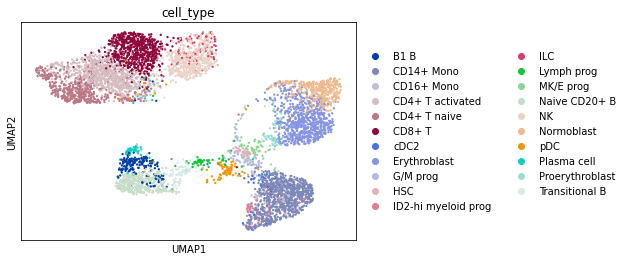

In [27]:
sc.pl.umap(atac, color = ["cell_type"])

In [43]:
model.save("/storage/groups/ml01/workspace/laura.martens/atac_poisson_data/models/poisson_atac_scvi_halved")

In [54]:
atac = adata[adata.obs.batch == 's1d1'].copy()

In [55]:
atac.layers["counts"].data = np.ceil(atac.layers["counts"].data/2)

In [56]:
atac.layers["counts"].max()

94.0

In [57]:
scvi.model.PEAKVI.setup_anndata(atac)

/storage/groups/ml01/code/laura.martens/github_repos/scvi-tools/scvi/data/anndata/_utils.py:97: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  warnings.warn(


In [60]:
model = scvi.model.PEAKVI(adata=atac)

In [ ]:
#setup logger
logger = WandbLogger(project=f"poisson_atac")
logger.watch(model.module, log='all')

#train model
model.train(logger=logger,train_size=0.8, validation_size=0.1, early_stopping=True)
wandb.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 49/500:  10%|▉         | 48/500 [07:59<1:13:31,  9.76s/it, loss=1.61e+08, v_num=zrss]